# NLP Subreddit Differentiation Project

## Problem Statment

Which model is more accurate for Subreddit Classification? A model  utilizing Countvectorizer and Naive Bayes or
a model utilizing TfidfVectorizer and Logistic Regression?


## Imports 

In [29]:
import requests
import pandas as pd
import time 
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

## Web-Scraping Data from Pushshift API

In [4]:
# Create empty DF
full_df= pd.DataFrame()

In [5]:
# Set options to view entire DF if needed
pd.set_option("max_rows", 10)
pd.set_option("max_columns", 1000000)

In [11]:
# Grab posts before epoch value an initiate DF

s_type = 'submission'
subreddit = 'science'
unix_time_stamp = 1627584697

url = f'https://api.pushshift.io/reddit/search/{s_type}/?subreddit={subreddit}&before={unix_time_stamp}&size=100'
res = requests.get(url)
if res.status_code == 200:
    post_list =  res.json()['data']

        
    full_df = pd.DataFrame(post_list)[['title', 'author', 'selftext', 'created_utc', 'subreddit']]
    
full_df.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        100 non-null    object
 1   author       100 non-null    object
 2   selftext     100 non-null    object
 3   created_utc  100 non-null    int64 
 4   subreddit    100 non-null    object
dtypes: int64(1), object(4)
memory usage: 4.0+ KB


In [13]:
# Going to use this code much like a function to scrape different subreddits

subreddit = 'religion'
for i in range(100):
    
    url = f'https://api.pushshift.io/reddit/search/{s_type}/?subreddit={subreddit}&before={full_df["created_utc"].min()}&size=100'


    res = requests.get(url)
    if res.status_code == 200:
        post_list =  res.json()['data']

        
        temp_df = pd.DataFrame(post_list)[['title', 'author','selftext', 'created_utc', 'subreddit']]
        full_df = pd.concat([full_df, temp_df])
        
        print(full_df.shape)
        print(full_df.nunique())
        print('wating until next pull...')
        time.sleep(5)


(10100, 5)
title           9645
author          3449
selftext          40
created_utc    10090
subreddit          2
dtype: int64
wating until next pull...
(10200, 5)
title           9743
author          3518
selftext          84
created_utc    10189
subreddit          2
dtype: int64
wating until next pull...
(10300, 5)
title           9841
author          3590
selftext         117
created_utc    10289
subreddit          2
dtype: int64
wating until next pull...
(10400, 5)
title           9934
author          3650
selftext         156
created_utc    10388
subreddit          2
dtype: int64
wating until next pull...
(10500, 5)
title          10030
author          3713
selftext         200
created_utc    10488
subreddit          2
dtype: int64
wating until next pull...
(10600, 5)
title          10124
author          3769
selftext         236
created_utc    10588
subreddit          2
dtype: int64
wating until next pull...
(10700, 5)
title          10216
author          3812
selftext         

## EDA

In [107]:
# full_df.to_csv('sci_rel.csv', index=False)
full_df = pd.read_csv('sci_rel.csv')
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        20000 non-null  object
 1   author       20000 non-null  object
 2   selftext     6422 non-null   object
 3   created_utc  20000 non-null  int64 
 4   subreddit    20000 non-null  object
 5   label        20000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 937.6+ KB


In [108]:
print(full_df.info())
print(full_df.selftext.value_counts()['[removed]'])
print(full_df.selftext.value_counts()['[deleted]'])

# Here we can see that many of the selftext has been removed or deleted

full_df.title.value_counts(sort = True)

# However, the titles remain. Then, lets use the titles as our data to predict our target subreddit.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        20000 non-null  object
 1   author       20000 non-null  object
 2   selftext     6422 non-null   object
 3   created_utc  20000 non-null  int64 
 4   subreddit    20000 non-null  object
 5   label        20000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 937.6+ KB
None
2412
338


New video by katholisch.de on YouTube                                                              109
Word's Of Shirdi Sai Baba                                                                           69
Word's of Shirdi Sai Baba                                                                           62
Weekly "What is my religion?" discussion                                                            20
10 Weird Signs Reveal That You Are Highly Intelligent, According To Science                         13
                                                                                                  ... 
Armageddon?                                                                                          1
Clinical Utility of SPECT Neuroimaging in the Diagnosis and Treatment of Traumatic Brain Injury      1
Atheists on Reddit                                                                                   1
Foolish Apes: On Reason and Religion | Helen Pluckrose and Bo Winegard   

## Pre-Processing and Modeling

In [109]:
full_df['label'] = full_df['subreddit'].map({'religion': 0, 'science': 1})
full_df.head()

,title,author,selftext,created_utc,subreddit,label
0,Let's Go! It's crunch time for climate action!,FossilBoi,NaN,1627583615,science,1
1,Patients’ perspectives on the experience of ab...,kmarkmohan,NaN,1627581399,science,1
2,Electrical activity of fungi: Spikes detection...,Memetic1,NaN,1627580992,science,1
3,Using fungal electrical activity for computing,Memetic1,NaN,1627580400,science,1
4,People often benefit from advice—when they enc...,geoff199,NaN,1627577763,science,1


In [110]:
X = full_df['title']
y = full_df['label']

In [111]:
# Check what we need to check in a classification problem.
y.value_counts(normalize = True)

0    0.5
1    0.5
Name: label, dtype: float64

In [112]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [113]:
# Instantiate a CountVectorizer with the default hyperparameters.
cvec = CountVectorizer()

In [114]:
# Fit the vectorizer on our corpus.
cvec.fit(X_train)

CountVectorizer()

In [115]:
# Transform the corpus.
X_train = cvec.transform(X_train)

In [116]:
X_train

<13400x20076 sparse matrix of type '<class 'numpy.int64'>'
	with 180109 stored elements in Compressed Sparse Row format>

In [117]:
# Transform test
X_test = cvec.transform(X_test)

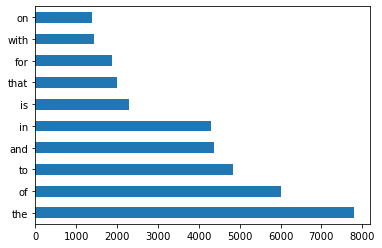

In [118]:
# convert training data to dataframe
X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names())

# plot top occuring words
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

In [119]:
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [120]:
y_test.value_counts(normalize=True)

0    0.5
1    0.5
Name: label, dtype: float64

### Pipeline Model Testing

In [121]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Bernoulli Naive Bayes (estimator)

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [122]:
# Estimate how your model will perform on unseen data
cross_val_score(pipe, X_train, y_train, cv=3).mean() 

0.9261936558664287

In [123]:
# Fit your model
pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('nb', MultinomialNB())])

In [124]:
# Training score
pipe.score(X_train, y_train)

0.9583582089552238

In [125]:
# Test score
pipe.score(X_test, y_test)

0.9357575757575758

### GridSearch Pipeline Testing

In [126]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

In [127]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe,
                  param_grid=pipe_params, 
                  cv=5) 

In [128]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [129]:
# What's the best score?
print(gs.best_score_)

0.9222388059701492


In [130]:
# Score model on training set.
gs.score(X_train, y_train)

0.9374626865671641

In [131]:
# Score model on testing set.
gs.score(X_test, y_test)

0.926060606060606

In [132]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
cm = confusion_matrix(y_test, preds)
tn, fp, fn, tp = cm.ravel()

Accuracy = (tp + tn) / (tn + fp + tp + fn)

print('Accuracy:', Accuracy)

Accuracy: 0.926060606060606


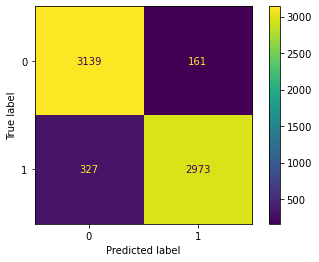

In [133]:
# View confusion matrix
ConfusionMatrixDisplay(cm).plot();

### Logistic Regression Model

In [134]:
# Instantiate and fit the transformer.
tvec = TfidfVectorizer()

pipe = Pipeline([
    ('tvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

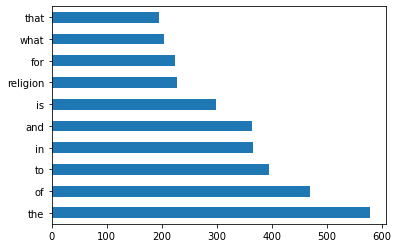

In [135]:
# convert training data to dataframe
X_train_df = pd.DataFrame(
    tvec.fit_transform(X_train).todense(), 
    columns=tvec.get_feature_names())

# plot top occuring words
X_train_df.sum().sort_values(
    ascending=False).head(10).plot(kind='barh');

In [136]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [137]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [138]:
# Instantiate GridSearchCV.

gs_tvec = GridSearchCV(pipe_tvec, 
                        param_grid = pipe_tvec_params, 
                        cv=5) 

In [139]:
# Fit GridSearch to training data.
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [140]:
# Score model on training set.
gs_tvec.score(X_train, y_train)

0.9483582089552239

In [141]:
# Score model on testing set.
gs_tvec.score(X_test, y_test)

0.9313636363636364

In [142]:
# Get predictions
preds_tvec = gs_tvec.predict(X_test)

# Save confusion matrix values
cm = confusion_matrix(y_test, preds_tvec)
tn, fp, fn, tp = cm.ravel()

# Calculate the specificity

Accuracy = (tp + tn) / (tn + fp + tp + fn)

print('Accuracy:', Accuracy)

Accuracy: 0.9313636363636364


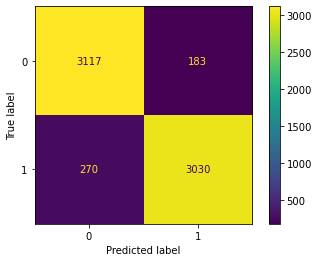

In [143]:
# visualize this

ConfusionMatrixDisplay(cm).plot();

## Analysis and Conclusions 

The LogReg model generated more accurate predictions than the Niave Bayes model, therefore I would recommend the LogReg model for subreddit classification.